# Analyse trajectoire etco2

Karine H.

### Idée : 

Prendre une variable de mesures des tables fct_ et regarder son évolution au cours de l'opération.  
Suivant le type du patient (immediate_extubation 1/0, secondary_intubation 1/0), regarder si on trouve des trajectoires similaires.  
(---> *regarder le papier fourni par Antoine sur l'analyse de trajectoire (avec R)*)

Sur ce notebook, exemple avec la variable etco2 de fct_respiratory car bon indicateur global d'après la doc


### Méthode:

- Besoin de merger la table fct_respiratory avec dim_patient
- Besoin de transposer la table pour que colonne = temps qui passe et lignes = mesuers de etco2 pour 1 patient
- Besoin de faire partir tous les patiens à 0:00 ---> jusque la durée de leur opération :
    - Tous les patiens n'ont pas la mếme durée, NA en fin de ligne ?
    - Garder en mémoire date de début, date de fin, durée opérations


### Remarques:

- Notebok d'après sur les data de master, seulement 94 patients dans les fct --> A retravailler avec les nouvelles tables du drive


- **/!\ BUGS /!\ :** Au cours du notebook on décele plusieurs types de bugs compliquant la construction du "transpose dataset"

    - 1) date_transplation = date_sortie_bloc dans dim_patient et pourtant dans fct_respiratory, l'opération dure toute la nuit donc concerne 2 jours

    - 2) Il peut manquer certaines minutes, exemple patient 303 qui passe de 14h26 à 14h28  
 id_patient : 303,  
 (solution temporaire -> obs gardées et traitées comme si la minuterie était continue) 

    - 3) Certains patients ont des opérations très longues avec coupures dans le temps.  
 Exemple patient 323 : opération commence à 2h11 jusque 20h27 puis reprend à 11h41 jusque 15h26 du jour d'après !)  
id_patient : 323, 305  
(solution temporaire -> obs enlevées du dataset)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# I. Download

------------------------------------------------------------------------

Cette partie peut être passée si on a deja le fichier df_respiratory_merged.csv

In [2]:
path = "../batch_5_transplant/data"
df_respiratory=pd.read_csv(path + "/fct_respiratory.csv",dtype={'id_patient':np.int32}, usecols=list(np.arange(1,19)))
df_patient=pd.read_csv(path + "/dim_patient.csv", 
                       usecols=["id_patient","immediate_extubation","secondary_intubation", 
                                "in_hospital_mortality","30_d_survival", "date_transplantation", "date_sortie_bloc"])

In [3]:
df_patient.head()

,id_patient,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
0,1,05/01/2012,1/5/12,0.0,0.0,0.0,1.0
1,2,08/01/2012,1/8/12,1.0,0.0,0.0,1.0
2,3,11/01/2012,1/12/12,0.0,0.0,0.0,1.0
3,4,15/01/2012,1/15/12,0.0,0.0,0.0,1.0
4,5,17/01/2012,1/18/12,0.0,0.0,0.0,1.0


In [4]:
df_patient.dtypes

id_patient                 int64
date_transplantation      object
date_sortie_bloc          object
immediate_extubation     float64
secondary_intubation     float64
in_hospital_mortality    float64
30_d_survival            float64
dtype: object

In [5]:
df_patient.iloc[214:303,:]

,id_patient,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
214,215,31/07/2015,8/1/15,1.0,0.0,0.0,1.0
215,216,8/20/15,8/20/15,0.0,1.0,1.0,1.0
216,217,8/28/15,8/29/15,0.0,0.0,0.0,1.0
217,218,8/29/15,8/30/15,1.0,0.0,0.0,1.0
218,219,9/6/15,9/7/15,1.0,0.0,0.0,1.0
219,220,9/8/15,9/8/15,0.0,0.0,0.0,1.0
220,221,9/13/15,9/14/15,0.0,0.0,1.0,0.0
221,222,9/25/15,9/26/15,0.0,0.0,0.0,1.0
222,223,10/10/15,10/10/15,0.0,0.0,0.0,1.0
223,224,10/10/15,10/10/15,0.0,1.0,0.0,1.0


Le format de la variable *date_transplatation* n'est pas le même pour une petite centaine de patients.  
Il faut faire une modification avant de passer en format datetime sinon le mois et le jour sont inversés

### I.1 Transform *date_transplantation*

In [6]:
day,month,year = df_patient['date_transplantation'].str.split('/').str

for i, (d,m,y) in enumerate(zip(day,month,year)):
    if type(y)==str and len(y)<4:
        #if type(y) != str then y is nan (type float) and has no len() 
        
        df_patient['date_transplantation'].iloc[i] = m+"/"+d+"/20"+y
        

/home/karine/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
df_patient.iloc[214:220,:]

,id_patient,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
214,215,31/07/2015,8/1/15,1.0,0.0,0.0,1.0
215,216,20/8/2015,8/20/15,0.0,1.0,1.0,1.0
216,217,28/8/2015,8/29/15,0.0,0.0,0.0,1.0
217,218,29/8/2015,8/30/15,1.0,0.0,0.0,1.0
218,219,6/9/2015,9/7/15,1.0,0.0,0.0,1.0
219,220,8/9/2015,9/8/15,0.0,0.0,0.0,1.0


In [8]:
df_patient.iloc[297:302,:]

,id_patient,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
297,298,2/11/2016,11/3/16,0.0,1.0,0.0,1.0
298,299,5/11/2016,11/6/16,0.0,0.0,0.0,1.0
299,300,17/11/2016,11/17/16,0.0,0.0,0.0,1.0
300,301,21/11/2016,11/21/16,0.0,0.0,1.0,0.0
301,302,25/11/2016,11/25/16,1.0,0.0,0.0,1.0


In [9]:
df_patient['date_transplantation']=pd.to_datetime(df_patient['date_transplantation'].astype('str'), format="%d/%m/%Y")

### I.2 Transform *date_sortie_bloc*

In [10]:
month,day,year = df_patient['date_sortie_bloc'].str.split('/').str
df_patient['date_sortie_bloc']=day+"/"+month+"/20"+year
df_patient['date_sortie_bloc']=pd.to_datetime(df_patient['date_sortie_bloc'].astype('str'), format="%d/%m/%Y")

In [11]:
df_patient.dtypes

id_patient                        int64
date_transplantation     datetime64[ns]
date_sortie_bloc         datetime64[ns]
immediate_extubation            float64
secondary_intubation            float64
in_hospital_mortality           float64
30_d_survival                   float64
dtype: object

In [12]:
df_patient.head()

,id_patient,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
0,1,2012-01-05,2012-01-05,0.0,0.0,0.0,1.0
1,2,2012-01-08,2012-01-08,1.0,0.0,0.0,1.0
2,3,2012-01-11,2012-01-12,0.0,0.0,0.0,1.0
3,4,2012-01-15,2012-01-15,0.0,0.0,0.0,1.0
4,5,2012-01-17,2012-01-18,0.0,0.0,0.0,1.0


### I.3 Merge df_respiratory and df_patient

In [13]:
df_respiratory.dtypes

etco2         float64
eto2          float64
fico2         float64
fin2o         float64
fr              int64
fr_ecg          int64
fio2          float64
mac             int64
peeptotal       int64
pmax            int64
pmean           int64
pplat           int64
rr_co2        float64
spo2          float64
svo2__m       float64
vt            float64
id_patient      int32
time           object
dtype: object

In [14]:
df_respiratory.shape

(64496, 18)

In [15]:
df_respiratory_merged=df_respiratory.merge(df_patient, how='left', on="id_patient")

In [16]:
df_respiratory_merged.shape

(64496, 24)

In [17]:
df_respiratory_merged.head()

,etco2,eto2,fico2,fin2o,fr,fr_ecg,fio2,mac,peeptotal,pmax,...,svo2__m,vt,id_patient,time,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival
0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,...,0.0,0.0,329,5:48,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,...,0.0,0.0,329,5:49,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0
2,0.0,21.0,0.0,0.0,0,0,21.0,0,1,1,...,0.0,0.0,329,5:50,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0
3,0.0,21.0,0.0,0.0,0,0,21.0,0,0,1,...,0.0,0.0,329,5:51,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0
4,0.0,21.0,0.0,0.0,0,0,21.0,0,0,1,...,0.0,0.0,329,5:52,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0


In [4]:
#etco2 ---> CO2 expiré = marqueur d'équilibre général (doc bdd expliquée)

### I.4 Concat Time & Date

In [18]:
id_patient = np.unique(df_respiratory_merged['id_patient'].values)
len(id_patient)

94

In [19]:
df_respiratory_merged['transplantation_dt'] = df_respiratory_merged['date_transplantation']

In [20]:
def create_dt_transplantation(data):
    
    start = datetime.datetime.now()
    print (start.time())
    
    for index, row in data.iterrows():
    
        time = datetime.datetime.strptime(row['time'].strip(), '%H:%M').time()

        if type(time.hour)==int and type(time.minute)==int :
            #otherwise, time is nan
            
            if index != 0 :
                if row['id_patient']==id_patient_1:
                    if time.hour < hour_1:
                        #operation is overnight and we are at day 2
                        if row['date_transplantation']==row['date_sortie_bloc']:
                            #prob with date_sortie_bloc
                            row['date_sortie_bloc'] = row['date_transplantation'] + datetime.timedelta(1)
                            
                        data.loc[index, 'transplantation_dt']=row['date_sortie_bloc'].replace(hour=time.hour, minute=time.minute)

                    else:
                        #same day than line before (day 0 or day 1)
                        data.loc[index, 'transplantation_dt']=transplantation_dt_1.replace(hour=time.hour, minute=time.minute)

                else:
                    #new patient, day 0
                    data.loc[index, 'transplantation_dt']=row['date_transplantation'].replace(hour=time.hour, minute=time.minute)
            else:
                #first patient, day 0
                data.loc[index, 'transplantation_dt']=row['date_transplantation'].replace(hour=time.hour, minute=time.minute)

        transplantation_dt_1 = data.loc[index, 'transplantation_dt']
        id_patient_1=row['id_patient']
        hour_1 = time.hour
    
        if index % 10000 == 0 :
            print (index)
        
    stop = datetime.datetime.now()
    print (stop.time())

In [21]:
create_dt_transplantation(df_respiratory_merged)

18:00:27.754737
0
10000
20000
30000
40000
50000
60000
18:01:37.637317


In [ ]:
#probleme avec le 323

In [24]:
df_respiratory_merged.head()

,etco2,eto2,fico2,fin2o,fr,fr_ecg,fio2,mac,peeptotal,pmax,...,vt,id_patient,time,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival,transplantation_dt
0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,...,0.0,329,5:48,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:48:00
1,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,...,0.0,329,5:49,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:49:00
2,0.0,21.0,0.0,0.0,0,0,21.0,0,1,1,...,0.0,329,5:50,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:50:00
3,0.0,21.0,0.0,0.0,0,0,21.0,0,0,1,...,0.0,329,5:51,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:51:00
4,0.0,21.0,0.0,0.0,0,0,21.0,0,0,1,...,0.0,329,5:52,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:52:00


In [25]:
df_respiratory_merged.to_csv("df_respiratory_merged.csv", sep=';')

# II. Focus on etco2

------------

Obj : regarder l'evolution de la variable pendant l'opération selon les patients

In [26]:
df_etco2=pd.read_csv("df_respiratory_merged.csv", sep=';', header=0, usecols=['id_patient', 'time', 'etco2', 'date_transplantation','date_sortie_bloc','transplantation_dt', 'immediate_extubation', 'secondary_intubation', 'in_hospital_mortality','30_d_survival'], 
                    parse_dates=['date_transplantation','date_sortie_bloc','transplantation_dt'])

In [27]:
df_etco2.head()

,etco2,id_patient,time,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival,transplantation_dt
0,0.0,329,5:48,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:48:00
1,0.0,329,5:49,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:49:00
2,0.0,329,5:50,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:50:00
3,0.0,329,5:51,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:51:00
4,0.0,329,5:52,2017-04-25,2017-04-25,1.0,1.0,0.0,1.0,2017-04-25 05:52:00


In [28]:
df_etco2.dtypes

etco2                           float64
id_patient                        int64
time                             object
date_transplantation     datetime64[ns]
date_sortie_bloc         datetime64[ns]
immediate_extubation            float64
secondary_intubation            float64
in_hospital_mortality           float64
30_d_survival                   float64
transplantation_dt       datetime64[ns]
dtype: object

In [184]:
### BUGSS

In [29]:
df_etco2[df_etco2['id_patient']==323]

,etco2,id_patient,time,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival,transplantation_dt
589,0.0,323,2:11,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:11:00
590,0.0,323,2:13,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:13:00
591,0.0,323,2:14,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:14:00
592,0.0,323,2:15,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:15:00
593,0.0,323,2:16,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:16:00
594,0.0,323,2:17,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:17:00
595,0.0,323,2:18,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:18:00
596,0.0,323,2:19,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:19:00
597,0.0,323,2:20,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:20:00
598,0.0,323,2:21,2017-03-28,2017-03-29,0.0,0.0,0.0,1.0,2017-03-28 02:21:00


In [30]:
print (df_etco2.loc[14336], df_etco2.loc[14337])

etco2                                      0
id_patient                               305
time                                   19:50
date_transplantation     2016-12-12 00:00:00
date_sortie_bloc         2016-12-13 00:00:00
immediate_extubation                       0
secondary_intubation                       0
in_hospital_mortality                      1
30_d_survival                              1
transplantation_dt       2016-12-12 19:50:00
Name: 14336, dtype: object etco2                                      0
id_patient                               305
time                                   18:13
date_transplantation     2016-12-12 00:00:00
date_sortie_bloc         2016-12-13 00:00:00
immediate_extubation                       0
secondary_intubation                       0
in_hospital_mortality                      1
30_d_survival                              1
transplantation_dt       2016-12-13 18:13:00
Name: 14337, dtype: object


In [31]:
df_etco2[df_etco2['id_patient']==405].head()

,etco2,id_patient,time,date_transplantation,date_sortie_bloc,immediate_extubation,secondary_intubation,in_hospital_mortality,30_d_survival,transplantation_dt
60425,0.0,405,6:29,NaT,2018-05-27,NaN,NaN,NaN,NaN,NaT
60426,0.0,405,6:30,NaT,2018-05-27,NaN,NaN,NaN,NaN,NaT
60427,0.0,405,6:31,NaT,2018-05-27,NaN,NaN,NaN,NaN,NaT
60428,0.0,405,6:32,NaT,2018-05-27,NaN,NaN,NaN,NaN,NaT
60429,0.0,405,6:33,NaT,2018-05-27,NaN,NaN,NaN,NaN,NaT


In [32]:
df_etco2 = df_etco2[df_etco2['id_patient']!=405]

### II.1 Change dataset

Changer le format du dataset où les colonnes sont les minutes de l'opération et 1 ligne = 1 patient

### Garder la date de début et de fin en mémoire

In [158]:
#debug id 300

In [33]:
id_=300
debug = df_etco2[df_etco2['id_patient']==id_]
debug.shape

(576, 10)

In [34]:
for i in range(debug.shape[0]-1):
    i=i+1
    indexx = debug.index[i]
    index_1 = debug.index[i-1]
    delta = debug.loc[indexx,'transplantation_dt']-debug.loc[index_1,'transplantation_dt']
    if (delta.seconds % 3600) // 60 > 1:
        # plus d'une minute entre les obs
        print (index_1, indexx)
        break
print ("##########################")        
print (debug.loc[index_1])
print ("    ")
print (debug.loc[indexx])

17676 17677
##########################
etco2                                      6
id_patient                               300
time                                   14:26
date_transplantation     2016-11-17 00:00:00
date_sortie_bloc         2016-11-17 00:00:00
immediate_extubation                       0
secondary_intubation                       0
in_hospital_mortality                      0
30_d_survival                              1
transplantation_dt       2016-11-17 14:26:00
Name: 17676, dtype: object
    
etco2                                    5.5
id_patient                               300
time                                   14:28
date_transplantation     2016-11-17 00:00:00
date_sortie_bloc         2016-11-17 00:00:00
immediate_extubation                       0
secondary_intubation                       0
in_hospital_mortality                      0
30_d_survival                              1
transplantation_dt       2016-11-17 14:28:00
Name: 17677, dtype: object


In [48]:
def transpose_data(dataf):
    """
    function that transpose the dataset + bug tracking
    """
    
    start = datetime.datetime.now()
    print (start.time())
    
    #to return
    bug_case_1 = []
    bug_case_2 = []
    bug_case_3 = []
    id_ok = []
    dataf_T = pd.DataFrame()

    id_patient = np.unique(dataf['id_patient'].values)
    
    i = 0
    for id_ in id_patient:
       
        #1. keep info of the operation time
    
        df = dataf[dataf['id_patient']==id_]
        F,L = df.index[0], df.index[-1]
        delta = df.loc[L,'transplantation_dt']-df.loc[F,'transplantation_dt']
        hours = delta.seconds // 3600
        minutes = (delta.seconds % 3600) // 60

        sub_df_1 = {'id_patient': id_, 'debut': df.loc[F,'transplantation_dt'], 'fin':df.loc[L,'transplantation_dt'], 
                    'duree': delta, 'immediate_extubation' : df.loc[F,'immediate_extubation'], 
                    'secondary_intubation' : df.loc[F,'secondary_intubation']}
        sub_df_1 = pd.DataFrame(data=sub_df_1, index=[0])


        #2. Create a list with item h:mm that represents the time of the operation from 0:00 to delta h:mm
        list_col = []
        for hour in range(hours+1) : 
            for mins in range(60):
                if hour == hours and mins == minutes+1:
                    break
                if mins < 10:
                    list_col.append('{}:0{}'.format(hour, mins))
                else:
                    list_col.append('{}:{}'.format(hour, mins))
    
       
        #3. transpose the observations of etco2
        data=dataf[dataf['id_patient']==id_]['etco2'].values
        
        #4 //////////////// DEBUGG \\\\\\\\\\\\\
        
        
        if (len(list_col) - len(data) >= 0) and  (len(list_col) - len(data) < 11) :
            
            
            if len(list_col) == len(data):
                id_ok.append(id_)
                
            else :
                # The operation timer  forgot 1 minute (or 10 max) --> cf bug id = 300
                # so list_col is longer than the number of etco2 operation
                bug_case_1.append(id_)
                tronc = len(list_col)-len(data)
                list_col = list_col[:-tronc]
            
            sub_df_2 = pd.DataFrame([data], columns=list_col)
            
            #. 5. concat the 2 dataframes
            sub_df = pd.concat([sub_df_1, sub_df_2], axis=1, sort=False)
        
            #6. Add to the global dff with all the patient
            dataf_T = dataf_T.append(sub_df, ignore_index=True)
     
        elif len(list_col) - len(data) > 10 :
            #more than 10 minutes cut in the etco2 obs
            bug_case_2.append(id_)
            
        else:
            #len(data) > len(list_col) : Operation too long +  temporally discontinuous(cf bug id 323)
            bug_case_3.append(id_)
            
        i = i+1
            
    stop = datetime.datetime.now()
    print (stop.time())
    return dataf_T, id_ok, bug_case_1, bug_case_2, bug_case_3

In [49]:
dataf_T, id_ok, bug_case_1, bug_case_2, bug_case_3 = transpose_data(df_etco2)

18:18:56.433462


/home/karine/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


18:18:58.236701


In [50]:
dataf_T

,0:00,0:01,0:02,0:03,0:04,0:05,0:06,0:07,0:08,0:09,...,9:56,9:57,9:58,9:59,debut,duree,fin,id_patient,immediate_extubation,secondary_intubation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.6,2.6,2.6,2.6,2013-10-16 03:13:00,11:41:00,2013-10-16 14:54:00,109,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2016-11-17 04:57:00,09:36:00,2016-11-17 14:33:00,300,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.1,3.2,3.6,3.2,2016-11-21 01:53:00,13:42:00,2016-11-21 15:35:00,301,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2016-11-25 02:52:00,09:42:00,2016-11-25 12:34:00,302,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2016-12-07 11:01:00,09:16:00,2016-12-07 20:17:00,304,0.0,0.0
5,7.8,7.8,7.4,9.3,7.6,7.7,7.9,7.8,7.7,7.5,...,6.7,5.7,0.0,7.8,2017-01-26 09:06:00,10:13:00,2017-01-26 19:19:00,312,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2017-02-16 05:04:00,09:42:00,2017-02-16 14:46:00,315,1.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2017-03-05 16:43:00,07:11:00,2017-03-05 23:54:00,318,1.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2017-04-09 08:58:00,07:52:00,2017-04-09 16:50:00,326,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,2017-04-25 05:48:00,09:48:00,2017-04-25 15:36:00,329,1.0,1.0


In [47]:
print(len(id_ok), len(bug_case_1), len(bug_case_2), len(bug_case_3))

59 10 14 10


### II.2 Graph


A REVOIR

In [51]:
#1/ immediate_extubation = 1 & secondary_intubation = 0

In [57]:
data_ok = dataf_T[(dataf_T['immediate_extubation']==1) & (dataf_T['secondary_intubation']==0) ]
data_ok = data_ok.drop(['debut','duree', 'fin', 'id_patient', 'immediate_extubation', 'secondary_intubation'], axis=1)

In [58]:
data_ok.shape

(24, 989)

Text(0,0.5,'ETCO2')

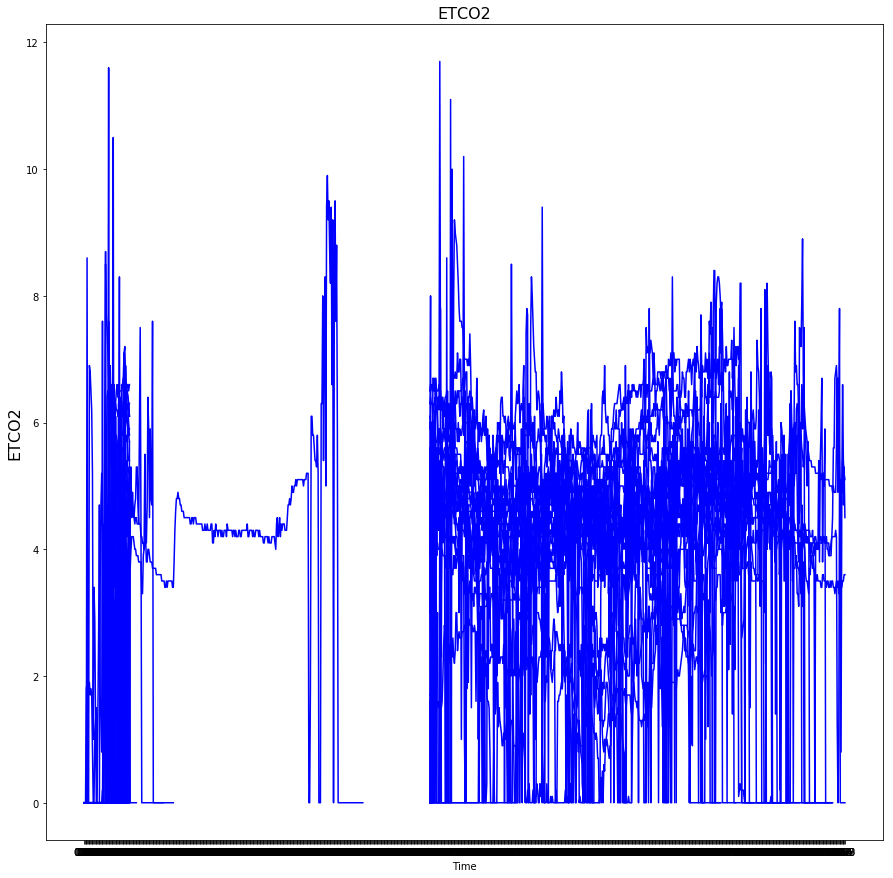

In [70]:
plt.figure(figsize=(15, 15 ))
plt.title("ETCO2", fontsize=16)
plt.plot(data_ok.columns, data_ok.T, color='blue')
plt.xlabel('Time')
plt.ylabel('ETCO2', fontsize=16)
#plt.legend(loc = 'lower right', fontsize = 16)

In [69]:
data_ko = dataf_T[(dataf_T['immediate_extubation']==1) & (dataf_T['secondary_intubation']==1) ]
data_ko = data_ko.drop(['debut','duree', 'fin', 'id_patient', 'immediate_extubation', 'secondary_intubation'], axis=1)
data_ko.shape

(3, 989)

Text(0,0.5,'ETCO2')

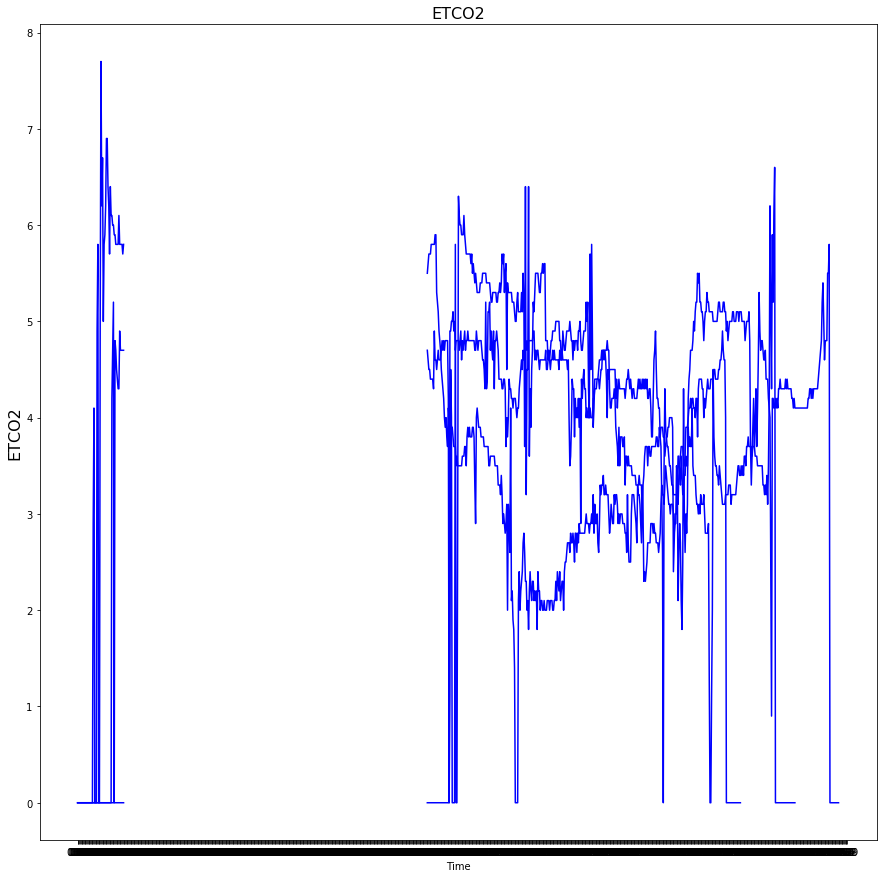

In [71]:
plt.figure(figsize=(15, 15 ))
plt.title("ETCO2", fontsize=16)
plt.plot(data_ko.columns, data_ko.T, color='blue')
plt.xlabel('Time')
plt.ylabel('ETCO2', fontsize=16)
#plt.legend(loc = 'lower right', fontsize = 16)